In [119]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd

In [122]:
np.random.seed(75)

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', '*', '^', 's', '.', 'p', 'o']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF) +
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(6)


In [5]:
def generateData(N, mu, sigma):
    return np.random.normal(mu, sigma, N)

* fitting function

In [6]:
def gaussian(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

def N_gaussian(x, N, mu, sigma):
    return N * gaussian(x, mu, sigma)

In [59]:
def plotGaussianLLHFitting(data, muA, sigA):
    # muA, sigA = 1.25, np.sqrt(0.11)
    xmin = data.min()
    xmax = data.max()
    Nbins = 30
    binwidth = (xmax-xmin)/Nbins

    NA = 1000
    # fitting of the data starts by setting up the histogram
    counts, bin_edges = np.histogram(data, bins=Nbins, range=(xmin, xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts
    sy = np.sqrt(counts)
    
    chi2 = Chi2Regression(N_gaussian, x, y, sy)
    minuit_chi2 = Minuit(chi2, N = NA, mu=muA, sigma=sigA)
    minuit_chi2.errordef = 0.5
    minuit_chi2.migrad()

    unbinned_llh = UnbinnedLH(N_gaussian, data, bound=(xmin,xmax), extended=True)
    minuit_unbinned = Minuit(unbinned_llh, N = NA, mu=muA, sigma=sigA)
    minuit_unbinned.errordef = 0.5
    minuit_unbinned.migrad()

    binned_llh = BinnedLH(N_gaussian, data, bound=(xmin,xmax), extended=True)
    minuit_binned = Minuit(binned_llh, N = NA, mu=muA, sigma=sigA)
    minuit_binned.errordef = 0.5
    minuit_binned.migrad

    ### multiply by the bandwidth!!!!!!!!!!!
    x_axis = np.linspace(xmin, xmax, 1000)
    y_chi2 = binwidth * N_gaussian(x_axis, *minuit_chi2.values)
    y_unbinned = binwidth * N_gaussian(x_axis, *minuit_unbinned.values)
    y_binned = binwidth * N_gaussian(x_axis, *minuit_binned.values)

    fig, ax = plt.subplots(figsize=(16, 10))
    ax.plot(x_axis, y_chi2, label='Chi2 Fit', marker = '')
    ax.plot(x_axis, y_unbinned, label='Unbinned LLH Fit', marker = '')
    ax.plot(x_axis, y_binned, label='Binned LLH Fit', marker = '')
    ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data(Poisson errors)', linestyle = 'None', color = 'k')
    ax.set_title(f'Gaussian LLH Fitting, mean = {muA:.2f}, sigma = {sigA:.2f}')
    ax.legend()

    d_chi2 = {'Chi2' : minuit_chi2.fval,
              'p-value' : stats.chi2.sf(minuit_chi2.fval, len(x)-3),
        'N':   [minuit_chi2.values['N'], minuit_chi2.errors['N']],
        'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
        'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
        }
    d_unbinned = {'LLH' : minuit_unbinned.fval,
        'N':   [minuit_unbinned.values['N'], minuit_unbinned.errors['N']],
     'mu':       [minuit_unbinned.values['mu'], minuit_unbinned.errors['mu']],
     'sigma':       [minuit_unbinned.values['sigma'], minuit_unbinned.errors['sigma']],
    }
    d_binned = {'LLH' : minuit_binned.fval,
        'N':   [minuit_binned.values['N'], minuit_binned.errors['N']],
     'mu':       [minuit_binned.values['mu'], minuit_binned.errors['mu']],
     'sigma':       [minuit_binned.values['sigma'], minuit_binned.errors['sigma']],
    }
    textLabel = ['Chi2\n','Unbinned LLH\n', 'Binned LLH\n']
    text_chi2 = nice_string_output(d_chi2, extra_spacing=2, decimals=3)
    text_unbinned = nice_string_output(d_unbinned, extra_spacing=2, decimals=3)
    text_binned = nice_string_output(d_binned, extra_spacing=2, decimals=3)
    texts = [text_chi2, text_unbinned, text_binned]
    text = ''
    for l, t in zip(textLabel, texts):
        text += l + t + '\n\n'
    add_text_to_ax(0.02, 0.95, text, ax, fontsize=14)


In [77]:
def compute_f(f, x, *par):
    try:
        return f(x, *par)
    except ValueError:
        return np.array([f(xi, *par) for xi in x])

In [78]:
def llh(f, data, *par):
    fx = compute_f(f, data, *par)
    likelihood = np.prod(fx)
    return likelihood

In [79]:
def ln_llh(f, data, *par):
    # Evaluate the pdf for the data with the given parameters
    fx = compute_f(f, data, *par)

    values = np.where(fx > 0, fx, np.finfo(float).tiny)
    
    # Take the log of the safe pdf values
    ln_values = np.log(values)
    
    # Sum the log values to get the log-likelihood
    return np.sum(ln_values)
    

In [123]:
def executeFit():
    NA = 1000
    muA, sigA = 1.25, np.sqrt(0.11)
    muB, sigB = 1.30, np.sqrt(0.50)
    # plotGaussianLLHFitting(generateData(NA, muB, sigB), muB, sigB)
    # plotGaussianLLHFitting(generateData(NA, muA, sigA), muA, sigA)
    
    def gaussian_A(x):
        return gaussian(x, muA, sigA)
    def gaussian_B(x):
        return gaussian(x, muB, sigB)
    
    sample = np.array([1.01, 1.30, 1.35, 1.44])
    
    print(llh(gaussian, sample, muA, sigA))
    print(llh(gaussian, sample, muB, sigB))
    print(ln_llh(gaussian, sample, muA, sigA))
    print(ln_llh(gaussian, sample, muB, sigB))
    
executeFit()

1.2918411137616792
0.09111254560865162
0.2560684208334785
-2.3956597716988


In [124]:
def showMaker(llh, sigs, mus, xlabel, ylabel, title = 'Raster Scan'):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set the extent of the image so that it matches the ranges of sigma and mu
    extent = [sigs[0], sigs[-1], mus[0], mus[-1]]

    # Use extent in imshow
    im = ax.imshow(llh, origin='lower', aspect='auto', cmap='GnBu', extent=extent)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.colorbar(im, ax=ax)
    plt.show()

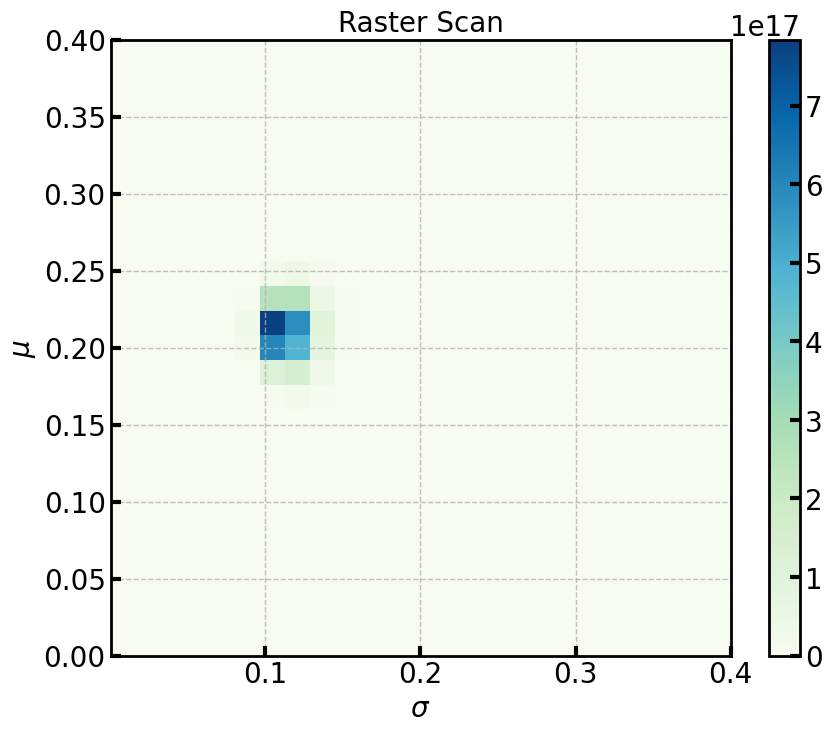

In [125]:
def llhMap():
    mu = 0.2
    sig = 0.1
    data = generateData(50, mu, sig)
    def gaussian_fit(x):
        return gaussian(x, mu, sig)
    N_resolution = 25
    sigs = np.linspace(0.0001, 0.4, N_resolution)
    mus = np.linspace(0, 0.4, N_resolution)
    llh_map = np.zeros((N_resolution, N_resolution))
    for i, mu in enumerate(mus):
        for j, sig in enumerate(sigs):
            llh_map[i, j] = llh(gaussian_fit, data)
    showMaker(llh_map, sigs, mus, r'$\sigma$', r'$\mu$')
    
llhMap()
